# Final Project: Machine Learning Applications
# *Goodreads meets NLP*
## Bachelor in Data Science and Engineering

<div>
<img src="attachment:9b620285-3e0e-4fe0-8bad-100ddbc27b71.png" height="300" width="300"/>
</div>

Done by:

* Alvaro Viejo Alonso (NIA: 100451677)
* Rodrigo Oliver Coimbra (NIA: 100451788)
* Héctor Tienda Cárdenas (NIA: 100)

## 0. Introduction and explanation

In this project we put in practice what was learned in the course of Machine Learning Applications on the area of Natural Language Processing (NLP). We will be analyzing a Goodreads book review dataset and we will be solving two learning tasks: regression (to predict the review score from the review text) and topic modelling (to predict the genre of the book that is being reviewed).

## 1. Data loading and preprocessing pipeline

### 1.1 Data loading

We are loading the `reviews_spoiler_reduced.csv` dataset which consists of three columns: `review_text` (string), `rating` (integer) and `book_genre` (factor).

We will be using `Dask` to apply the tokenization and lemmatization with spaCy of the dataset. This library parallelizes common Python libraries such as `Pandas` or `Numpy` and allows for better scalability, for more information check their [FAQ](https://docs.dask.org/en/stable/faq.html). According to `Dask`'s official webpage: "Dask is used within the world’s largest banks, national labs, retailers, technology companies, and government agencies".

In [1]:
%%time
# !conda install -c conda-forge spacy
# !conda install -c conda-forge cupy`
# !python -m spacy download en_core_web_trf

###### DATA STORAGE & MANIPULATION ######
import pandas as pd
import dask.dataframe as dd
import dask.bag as db
import dask.config
import numpy as np
import csv

###### DATA VISUALIZATION ######
import matplotlib.pyplot as plt
import seaborn as sns

###### NLP ######
import spacy
import gensim

###### MACHINE LEARNING ######
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

###### PARALLELIZATION ######
from joblib import parallel_backend

###### OTHERS ######
import os
from tqdm.auto import tqdm
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar


# Create Pandas method to provide tqdm progress
tqdm.pandas()

# Use TqdCallback globally
cb = TqdmCallback(desc="global")
cb.register()

CPU times: user 8.77 s, sys: 2.88 s, total: 11.6 s
Wall time: 42.7 s


In [2]:
%%time
# Load the sample dataset
sample_dd = dd.read_csv("data/reviews_spoiler_reduced.csv", encoding="utf-8", usecols=lambda c: c != 'Unnamed: 0')
sample_dd.persist()

global:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 357 ms, sys: 66.7 ms, total: 424 ms
Wall time: 1.67 s


,review_text,rating,book_genre
npartitions=1,,,
,object,int64,object
,...,...,...


In [3]:
# Print the sample dataset
sample_dd.head()

global:   0%|          | 0/2 [00:00<?, ?it/s]

,review_text,rating,book_genre
0,"I originally gave this three stars, but it was...",4,children
1,"they didnt actually quit, they just wrote lett...",4,children
2,This story follows a family consisting of a fa...,5,children
3,"I don't remember reading this book in school, ...",4,children
4,Read for the 2016 YA/MG Book Battle. This book...,5,children


We load `spaCy`'s `en_core_web_trf` model which is optimized for GPU (CUDA) usage and it is larger and slower but its provide more accuracy. `spaCy` is a state-of-the-art open-source library for Natural Language Processing (NLP) that is held in high regard by practicioners all around the world.

The spaCy library provides a trained model with several components that share the `tok2vec`component.



![image.png](attachment:image.png)

The first `tok2vec` attribute corresponds is this case tou our `transformer`, and it will be responsible for tokenizing the book reviews. 

Then we have the `tagger`which assings the POS (part-of-speech) tags to each word, followed by the `parser`that is tasked with assigning dependency labels. These are very important for spaCy's internal mechanisms and this analysis is further extended by `attribute_ruler` which contains specific rules for each language.

Finally we have the `lemmatizer` which draws from `attribute_ruler` to homogenize the text corpus by reducing the number of word variants (i.e. assigns base forms).

The `ner` (Named Entity Recognizer) is devoted to detecting and labelling named entities that have a specific meaning such as `Tencent` (corporation), `John` (person), `spaniards` (group of people) or `UN` (organization).

In [4]:
%%time
# Load the en_core_web_trf model
nlp = spacy.load("en_core_web_trf")

CPU times: user 3.19 s, sys: 1.57 s, total: 4.76 s
Wall time: 9.13 s


In [5]:
# Print spaCy's nlp pipe parts
print(nlp.pipe_names)

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### 1.2 Preprocessing

#### 1.2.1 Tokenization, homogenization, cleaning

In this subsection we will be performing tokenization, homegenization and cleaning using the SpaCy Python library. The `preprocess_text` function is that with the tokenization and lemmatization of all the book reviews and the removel of any stopwords (very common words), punctuation marks and whitespaces. All words are also converted to lowercase for uniformity.

SpaCy was used as it provides state-of-the-art tools in NLP and allows for a streamlined, yet powerful approach to data preprocessing.

In [6]:
def preprocess_text(text, model):
    """
    This function is tasked with tokenizing and lemmatizing the text while
    also removing stopwords, punctuation and whitespaces.
    It returns the remaining token as a string.
    """
    doc = model(text)
    tokens = [
                token.lemma_.lower().strip() \
                    for token in doc \
                        if token.is_alpha \
                        and not token.is_stop \
                        and not token.is_punct \
                        and not token.is_space
    ]
    return tokens

In [7]:
%%time
# Create a new column in the dataset to store the new, cleaned reviews
# for this we will be using Dask's apply function that parallelizes this
# process providing a boost in computation speed
sample_dd["doc"] = sample_dd["review_text"].apply(lambda x: preprocess_text(x, nlp), meta=("text", "str"))

CPU times: user 8.46 s, sys: 2.11 s, total: 10.6 s
Wall time: 10.1 s


In [8]:
%%time
# Save the tokenized and lemmatized dataset
PARQUET_FILE = "data/reviews_spoiler_reduced_tokenized.parquet"

DASK_WORKERS = os.cpu_count() * 2 - 2

sample_dd_parquet = sample_dd.copy()
sample_dd_parquet["doc"] = sample_dd_parquet["doc"].apply(str, meta=("text", "str"))
sample_dd_parquet.to_parquet(PARQUET_FILE)

global:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 20min 49s, sys: 15.7 s, total: 21min 4s
Wall time: 3min 37s


In [9]:
os.system('notify-send "Execution finished." "Cell execution has finished."')

0

In [33]:
%%time
# Obtain the Pandas Dataframe
sample_df = pd.read_parquet(PARQUET_FILE).reset_index(drop=True)

CPU times: user 10.2 ms, sys: 5.99 ms, total: 16.1 ms
Wall time: 11.5 ms


In [34]:
sample_df.dtypes

review_text    object
rating          int64
book_genre     object
doc            object
dtype: object

In [35]:
sample_df.head()

,review_text,rating,book_genre,doc
0,"I originally gave this three stars, but it was...",4,children,"['originally', 'give', 'star', 'close', 'decid..."
1,"they didnt actually quit, they just wrote lett...",4,children,"['nt', 'actually', 'quit', 'write', 'letter', ..."
2,This story follows a family consisting of a fa...,5,children,"['story', 'follow', 'family', 'consist', 'fath..."
3,"I don't remember reading this book in school, ...",4,children,"['remember', 'read', 'book', 'school', 'decide..."
4,Read for the 2016 YA/MG Book Battle. This book...,5,children,"['read', 'ya', 'mg', 'book', 'battle', 'book',..."


In [36]:
%%time
# Count the number of appearances of each rating value
rating_counts = sample_df["rating"].value_counts()

rating_counts

CPU times: user 4.17 ms, sys: 0 ns, total: 4.17 ms
Wall time: 3.49 ms


rating
4    172
3    124
5     94
2     47
1      9
0      2
Name: count, dtype: int64

In [37]:
# Count the number of appearances of each book genre
genre_counts = sample_df["book_genre"].value_counts()

genre_counts

book_genre
children       56
comic          56
fantasy        56
history        56
poetry         56
romance        56
thriller       56
young_adult    56
Name: count, dtype: int64

In [84]:
#TODO: Comment the distribution of values in the two categories

## 2. Basic text vectorization

In the text vectorization part we will be analyzing the following vectorization schemes:

- Bag-of-Words vs. TF-IDF representation
- Word2vec/FastText vs. Doc2Vec
- Theme extraction and vector representation using LDA.

In this part we will be using Gensim.

### 2.1 Gensim Corpus and N-grams detection

#### 2.1.1 Gensim Corpus

In [85]:
%%time
sample_corpus = sample_df["doc"].tolist()

# To avoid errors with Phraser
#sample_corpus = [str(el) for el in sample_corpus]

CPU times: user 101 µs, sys: 0 ns, total: 101 µs
Wall time: 107 µs


In [86]:
print(f"Number of documents in corpus: {len(sample_corpus)}")
print(f"First review text: \n {sample_corpus[0]}")

Number of documents in corpus: 448
First review text: 
 ['originally', 'give', 'star', 'close', 'decide', 'miserly', 'bump', 'kid', 'kid', 'mean', 'young', 'middling', 'teenager', 'maybe', 'advanced', 'pre', 'teen', 'like', 'read', 'scary', 'story', 'outer', 'limits', 'twilight', 'zone', 'kind', 'feel', 'apparently', 'mean', 'middle', 'grade', 'book', 'storytelling', 'style', 'like', 'element', 'bit', 'gruesome', 'thing', 'particular', 'detail', 'end', 'spoiler', 'tag', 'scare', 'point', 'threshold', 'scare', 'thing', 'kind', 'low', 'scared', 'see', 'blair', 'witch', 'project', 'assure', 'total', 'wimp', 'scare', 'thematically', 'friendship', 'conform', 'ideal', 'normalcy', 'perfection', 'temptation', 'try', 'change', 'people', 'feel', 'like', 'story', 'element', 'manipulate', 'maximum', 'deftness', 'handle', 'reasonably', 'like', 'visual', 'design', 'book', 'endpaper', 'pattern', 'creepy', 'bug', 'text', 'drawing', 'small', 'bug', 'appear', 'margin', 'thing', 'gross', 'see', 'come', '

<Axes: ylabel='Count'>

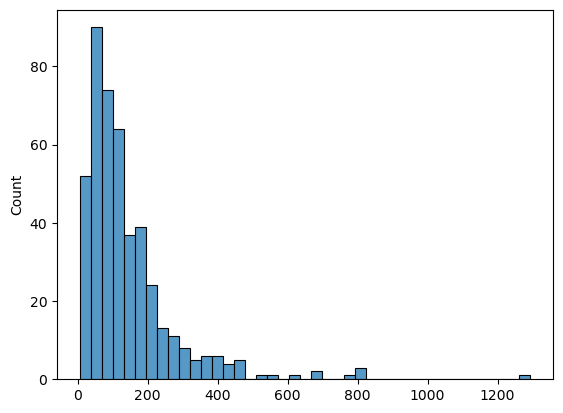

In [87]:
sns.histplot(data=sample_corpus, x=[len(doc) for doc in sample_corpus])

#### 2.1.2 N-grams

More broadly, an *n*-gram is a contiguous sequence of *n* terms from text sample. The *n* prefix denotes the size of the sequence. This notion is specially useful to encapsulate words that have a specific meaning when put together, e.g., *United Kingdom* or *Machine Learning*.

By using `gensim.models.phrases.Phrases` we are able to construct these *n*-grams (we are interested in finding *bigrams* and larger) that meet a certain statistical criteria.

In [88]:
%%time
phrase_model = gensim.models.phrases.Phrases(sample_corpus, min_count=2, threshold=30)
sample_corpus = [el for el in phrase_model[sample_corpus]]

sample_df["doc"] = sample_corpus

CPU times: user 112 ms, sys: 999 µs, total: 113 ms
Wall time: 113 ms


In [89]:
%%time
# Save the tokenized and lemmatized dataset with N-grams
sample_df.to_csv("data/reviews_spoiler_reduced_n_grams-*.csv")

CPU times: user 29.6 ms, sys: 2.99 ms, total: 32.5 ms
Wall time: 35 ms


### 2.2 Gensim dictionary

#### 2.2.1 Dictionary creation

Gensim's `Dictionary` is tasked with storing the mappings between the normalized words and their IDs, which are integer values.

In [90]:
%%time
# Create dictionary of tokens
D = gensim.corpora.Dictionary(sample_corpus)
n_tokens = len(D)

CPU times: user 40.1 ms, sys: 8 µs, total: 40.1 ms
Wall time: 39.9 ms


In [91]:
print(f"The postive dictionary contains {n_tokens} terms.")

The postive dictionary contains 9442 terms.


In [92]:
print(f"The first twenty terms in the dictionary are:\
\n{[D[i] for i in range(20)]}")

The first twenty terms in the dictionary are:
['advanced', 'apparently', 'appear', 'assure', 'author', 'bit', 'blair', 'book', 'bug', 'bump', 'cannibalism', 'change', 'close', 'come', 'confirm', 'conform', 'conformer', 'couple', 'creepy', 'decide']


`Dictionary` has many useful attributes such as:

* `token2id | dtype=dict(int,int)`: responsible for the reverse mapping `token` -> `token_id`;
* `cfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([sum(token) for token in document if token == token_id])`
* `dfs | dtype=dict(int,int)`: responsible for mapping `token_id` -> `sum([1 for document in collection for token_i in document if token_i == token_id])`

We now proceed to a more exploratory analysis in order to better understand the data. In order to do so we will be performing some modifications to it.

#### 2.2.2 Further cleaning

In [93]:
%%time
# Create a list of tuples with token and token frequency per document
token_ndocs = [(D[token_id], token_freq) for token_id, token_freq in D.dfs.items()]

CPU times: user 7.8 ms, sys: 0 ns, total: 7.8 ms
Wall time: 7.87 ms


In [94]:
%%time
# Create dataframe with two columns from the tuple list
token_df = pd.DataFrame(token_ndocs, columns=["token", "ndocs"])

# Sort dataframe according to column ndocs
token_df = token_df.sort_values(by="ndocs", ascending=False)

CPU times: user 11.9 ms, sys: 7 µs, total: 11.9 ms
Wall time: 11.1 ms


In [95]:
token_df

,token,ndocs
26,book,337
14,like,316
15,read,291
17,story,240
240,character,228
...,...,...
5095,bestseller,1
5092,ambitious,1
5091,stunningly,1
5090,anthony_doerr,1


We can clearly see that there are several tokens that appear exactly in only one document. These tokens are not important for our analysis and may therefore be discarded.

*Did you know?:* In linguistics words that only appear once in a given corpus are called **[hapax legomena](https://en.wikipedia.org/wiki/Hapax_legomenon)** (plural form of the transliteration from the Greek ἅπαξ λεγόμενον).

When referring to two, three or four occurrences we use the forms *dis legomenon*, *tris legomenon*, and *tetrakis legomenon*, respectively (note that the plural form is *legomena*).

In [96]:
# Count the number of tokens that appear exactly once in the entire corpus
n_hapax_legomena = token_df[token_df.ndocs == 1].shape[0]

print(f"Number of hapax legomena: {n_hapax_legomena}")

Number of hapax legomena: 5112


Here we can see that there are several *hapax legomena*. Let's improve this analysis by seeing what is the distribution of tokens with respect to the number of times they appear in the text corpus.

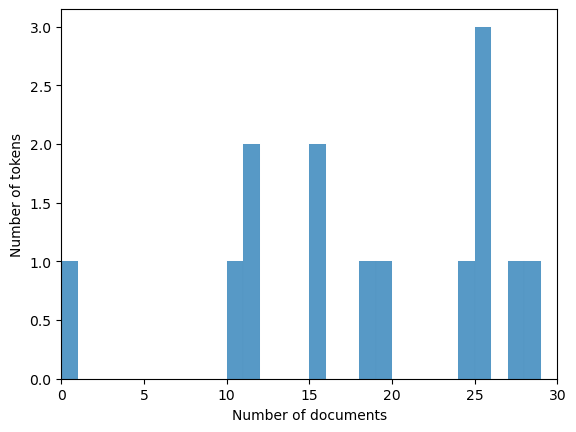

In [97]:
# Store token frequencies in corpus
freq_array = np.zeros(30)
for i in range(30):
    freq_array[i] = token_df[token_df.ndocs == i].shape[0]

# Plot number of words per frequency
sns.histplot(data=freq_array, binwidth=1)
plt.xlabel("Number of documents")
plt.ylabel("Number of tokens")
plt.xlim(0, 30) # Set the x-axis limits
plt.show()


Out of curisioty let's extract the ten most and least common tokens.

In [98]:
# Obtain the most/least common tokens in terms of document occurance
# this could have been easily done with token_df.head(10) 
# and token_df.tail(10)
lm_common_tokens = [
    token_df.iloc[-10:]["token"],
    token_df.iloc[:10]["token"]
]

print(f"The ten most common tokens are:\n{lm_common_tokens[1]}")
print(f"\nThe ten least common tokens are:\n{lm_common_tokens[0]}")


The ten most common tokens are:
26          book
14          like
15          read
17         story
240    character
171        think
265         love
380         good
23          feel
151         know
Name: token, dtype: object

The ten least common tokens are:
5089          acclaim
5105      marie_laure
5104          clarify
5103          catalog
5099      devastation
5095       bestseller
5092        ambitious
5091       stunningly
5090    anthony_doerr
9441      orientation
Name: token, dtype: object


It is known that tokens with very few or very high appeareance frequencies may stymie Natural Processing Language performance. Why? This is because we are unable to extract meaningful patterns across documents using rare words and the converse happens with very common words, they become uninformative as they are present almost anywhere.

There is also the possibility that some of these very strange words are, in fact, just spelling errors.

In order to do this we will be using `Dictionary`method `filter_extremes`which takes two values as input (lower bound, upper bound).

In [99]:
%%time
# Minimum number of documents that store a given token
MIN_APPEARANCES = 4 # tetrakis legomena

# Maximum proportion of documents that store a given token
MAX_FREQUENCY = .85

# Apply the filter_extremes function
D.filter_extremes(no_below=MIN_APPEARANCES, no_above=MAX_FREQUENCY)
n_tokens = len(D)

print(f"The filtered dictionary contains {n_tokens} terms.\n")

The filtered dictionary contains 2155 terms.

CPU times: user 5.08 ms, sys: 975 µs, total: 6.05 ms
Wall time: 5.94 ms


We now save the newly filtered data:

In [100]:
corpus_df = []
for sent in sample_corpus:
  corpus_df.append([token for token in sent if token in D.token2id.keys()])

sample_df["clean_doc"] = corpus_df

In [101]:
sample_df

,review_text,rating,book_genre,doc,clean_doc
0,"I originally gave this three stars, but it was...",4,children,"[originally, give_star, close, decide, miserly...","[give_star, close, decide, kid, kid, mean, you..."
1,"they didnt actually quit, they just wrote lett...",4,children,"[nt, actually, quit, write, letter, complaint,...","[nt, actually, write, letter, complaint, tell,..."
2,This story follows a family consisting of a fa...,5,children,"[story, follow, family, consist, father, mothe...","[story, follow, family, consist, father, mothe..."
3,"I don't remember reading this book in school, ...",4,children,"[remember, read, book, school, decide, try, lo...","[remember, read, book, school, decide, try, lo..."
4,Read for the 2016 YA/MG Book Battle. This book...,5,children,"[read, ya, mg, book, battle, book, simply, cha...","[read, ya, book, battle, book, simply, charmin..."
...,...,...,...,...,...
443,Seriously dunno what to think.. This was my re...,3,young_adult,"[seriously, dunno, think, reaction, novel, con...","[seriously, think, reaction, novel, concept, b..."
444,"Possible trigger warnings: abuse*, teen pregna...",5,young_adult,"[possible, trigger_warning, abuse, teen, pregn...","[possible, trigger_warning, abuse, teen, suici..."
445,"I really loved this! ""To all the boys I've lov...",5,young_adult,"[love, boy, love, unique, diverse, novel, wond...","[love, boy, love, unique, diverse, novel, wond..."
446,"I wanted to give this book three stars, and I ...",4,young_adult,"[want, book, star, think, half, quarter, book,...","[want, book, star, think, half, quarter, book,..."


### 2.3 Bag-of-Words (BoW)

**Bag-of-Words (BoW)** is a technique used for text representation simplification in the realm of Natural Language Processing (NLP). The BoW representation consists in storing the number of appearances of each word for each document in the corpus.

The limitations of the BoW representation are clear: it is an extention of the One-Hot Encoding one and it discards grammatical and word order/word position information.

In order to obtain a BoW representation of our corpus we will be using the `doc2bow`provided by Gensim's `Dictionary`. Data is stored in a sparse vector representation with a tuple of `int`s denoting the `token_id` and the other its frequency.

In [102]:
%%time
# Store the BoW representation of all tokens per corpus document
reviews_bow = [D.doc2bow(doc) for doc in corpus_df]

CPU times: user 47.7 ms, sys: 981 µs, total: 48.7 ms
Wall time: 48.1 ms


### 2.4 Term frequency - Inverse document frequency (TF-IDF)

**Term frequency - Inverse document frequency (TF-IDF)** is another technique for text representation simplification for NLP. It takes into account more information and factors than the simpler, BoW transformation.

TF-IDF has the following property: it gives a high value for a term in a given document if that term is common within that document and rare otherwise, i.e., in the rest of the corpus. This means that while BoW is easier to interpret, TF-IDF provides more information about the commnality of certain words and is conditioned by the entire corpus by the IDF.

As expressed previously, TF-IDF is constituted by two different factors: *term frequency* and *inverse document frequency*.

* **Term frequency**: number of time a given word appears in a document.
$$\text{TF}(w, d) = \text{BoW}(w,d)$$

* **Inverse document frequency**: logarithm of the number of documents in the corpus divided by the number of documents with word $w$.
$$\text{IDF}(w) = \text{log}\left(\frac{\#\text{docs}}{\#\text{docs with term } w}\right)$$

So the TF-IDF is given by:
$$\text{TF-IDF} = \text{TF}(w,d) \times \text{IDF}(w)$$

**Note**: Because TF-IDF takes into account the entirety of the corpus in its computations for each element of the document-token matrix is not *not* possible to update it in Gensim's implementation by adding more documents as this would entail a loss of consistency.

In [103]:
%%time
# Build TF-IDF model with Gensim's TfidfModel
tfidf = gensim.models.TfidfModel(reviews_bow)

CPU times: user 21.8 ms, sys: 1.92 ms, total: 23.7 ms
Wall time: 23 ms


We can now use `reviews_tfidf`to convert any vector from the BoW representation into the new one, using TF-IDF.

In [104]:
%%time
reviews_tfidf = tfidf[reviews_bow]

CPU times: user 0 ns, sys: 308 µs, total: 308 µs
Wall time: 329 µs


### 2.5 Using Sklearn/CUML

In [105]:
#TODO -> This is optional

## 3. Word embeddings and Machine Learning Tasks

As we previously saw, both BoW and TF-IDF are quite limited and discard a lot of useful information that would be beneficial for our Machine Learning algorithms.

Then we have the distributional hypothesis which states that words that frequently appear in similar contexts, tend to have similar meaning. This means we can more or less equate *capture meaning* with *capture context* and vice-versa, and this is precisely what we will be doing.

This implies that we have to include the context information into the **word embeddings**, something that neither BoW nor TF-IDF are capable of doing.

**Word embeddings** are the vector representation of words in such a manner that words with similar meaning or characteristics have close representations. Their proximity/closeness is measured by the dot product between the vector forms.

There are three main ways of creating word embeddings:

* **Count-baed methods**: 
* **Prediction-based methods**: e.g., Word2Vec
* **Hybrid methods**: e.g., Glove

### 3.1 Word2Vec

#### 3.1.1 Model creation

In [106]:
#TODO: Añadir explicación de qué es Word2Vec y cómo funciona
#TODO: Añadir también sus ventajas como prediction-based method

There are two Word2Vec variants that are worth mentioning: **Skip-gram** and **CBOW**. They take the opposite approach with respect to each other: **Skip-gram** aims to predict the surronding context word from a central word while **CBOW** aims to predict the central word from the surrounding context.

Both Skip-gram and CBOW are expensive to compute due to softmax normalization; there is a solution, though. It has been checked by Milokov that a selection of 5 to 20 (in small datasets) and of 2 to 5 (in large datasets) may be sufficient to obtain good learning and to capture the relationships between words in a decent manner.

In [107]:
#TODO: Añadir desventajas de Word2Vec

In [108]:
# Define parameters for Word2Vec model

#XXX: How are going to choose vector size & window size?
VECTOR_SIZE = 200
WINDOW_SIZE = 5
SEED_VALUE = 42

In [109]:
%%time
# Create the Word2Vec skip-gram model
# sg=1 --> Skip-gram
# min_count=0 because we have already removed
# rare terms from corpus_df
model_w2v_skip = gensim.models.Word2Vec(
                                            sentences=corpus_df,
                                            vector_size=VECTOR_SIZE,
                                            window=WINDOW_SIZE,
                                            seed=SEED_VALUE,
                                            sg=1,
                                            min_count=0,
                                            workers=os.cpu_count()
                                        )

#NOTE: Word2Vec has an excellent integration with Gensim Phrases
# but we are not using it as corpus_df has already been transformed
# with all these functions previously.

# Fetch word vectors from the model
wv_w2v_skip = model_w2v_skip.wv

# Free memory from the entire model (we are not going to use it)
del model_w2v_skip

# Save model in file
wv_w2v_skip.save("wordvectors/wv_w2v_skip.wordvectors")


# Load back with memory-mapping = read-only, shared across processes.
wv_skip = gensim.models.KeyedVectors.load("wordvectors/wv_w2v_skip.wordvectors", mmap='r')

CPU times: user 2.03 s, sys: 13 ms, total: 2.04 s
Wall time: 533 ms


With Gensim it is easy to obtain the Numpy vector of a given word, for example:

In [110]:
# Obtain Numpy vector of word "book"
wv_skip["book"]

array([ 0.22273919,  0.11665601,  0.0214804 ,  0.04796354,  0.0497968 ,
        0.04497398,  0.16328764,  0.14926846, -0.00864493, -0.13655776,
       -0.11182716,  0.02343028,  0.07616067,  0.15639631, -0.029301  ,
       -0.14865701, -0.03151288, -0.13948907, -0.10868864,  0.0993316 ,
        0.05700642,  0.06626663,  0.00548794,  0.16054818,  0.08956968,
        0.17128663, -0.02232059,  0.20472455,  0.05299255, -0.08432101,
       -0.03641409, -0.12873517, -0.06190045, -0.02916058, -0.16432051,
        0.07191813,  0.10581651, -0.13762286, -0.00941546,  0.02624808,
       -0.01695297, -0.11699519,  0.22470357, -0.04393125, -0.01310993,
        0.08824012,  0.1873128 ,  0.12938   ,  0.19151248,  0.00507048,
       -0.10553668, -0.1338247 , -0.04793776, -0.00932118, -0.09125448,
       -0.09109805,  0.02735599,  0.03018407, -0.0655194 ,  0.0866647 ,
        0.01472576, -0.06818004, -0.114697  ,  0.09314054, -0.02404449,
       -0.02279196,  0.05459355,  0.06855422, -0.18021978,  0.01

We can also obtain the most similar words to `book` according to the Word2Vec word vector representation.

In [111]:
# Obtain the ten most similar words to "book"
wv_skip.most_similar("book", topn=10)

[('read', 0.9971815943717957),
 ('enjoy', 0.9940463900566101),
 ('like', 0.9915555119514465),
 ('series', 0.9912380576133728),
 ('star', 0.9888851642608643),
 ('great', 0.988571286201477),
 ('good', 0.9879209995269775),
 ('feel', 0.9873051643371582),
 ('review', 0.9861339330673218),
 ('interesting', 0.9855006337165833)]

#### 3.1.2 Model visualization

To get an idea of the model's performance we can visualize the embeddings. It is not possible to visualize even low-dimensional vectors of four dimensions so we will have to resort to dimensionality reduction if we are to be able to plot the word vectors.

In order to do this we will be employing [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) which stands for *t-distributed Stochastic Neighbor Embedding*. We will be using Sklearn's implementation.

In [112]:
%%time
# Initialize t-SNE

with parallel_backend("threading", n_jobs=os.cpu_count()):
    t_sne = TSNE(init="pca")
    wv_skip_tsne = t_sne.fit_transform(wv_skip.vectors)



CPU times: user 23.3 s, sys: 1.07 s, total: 24.4 s
Wall time: 8.25 s


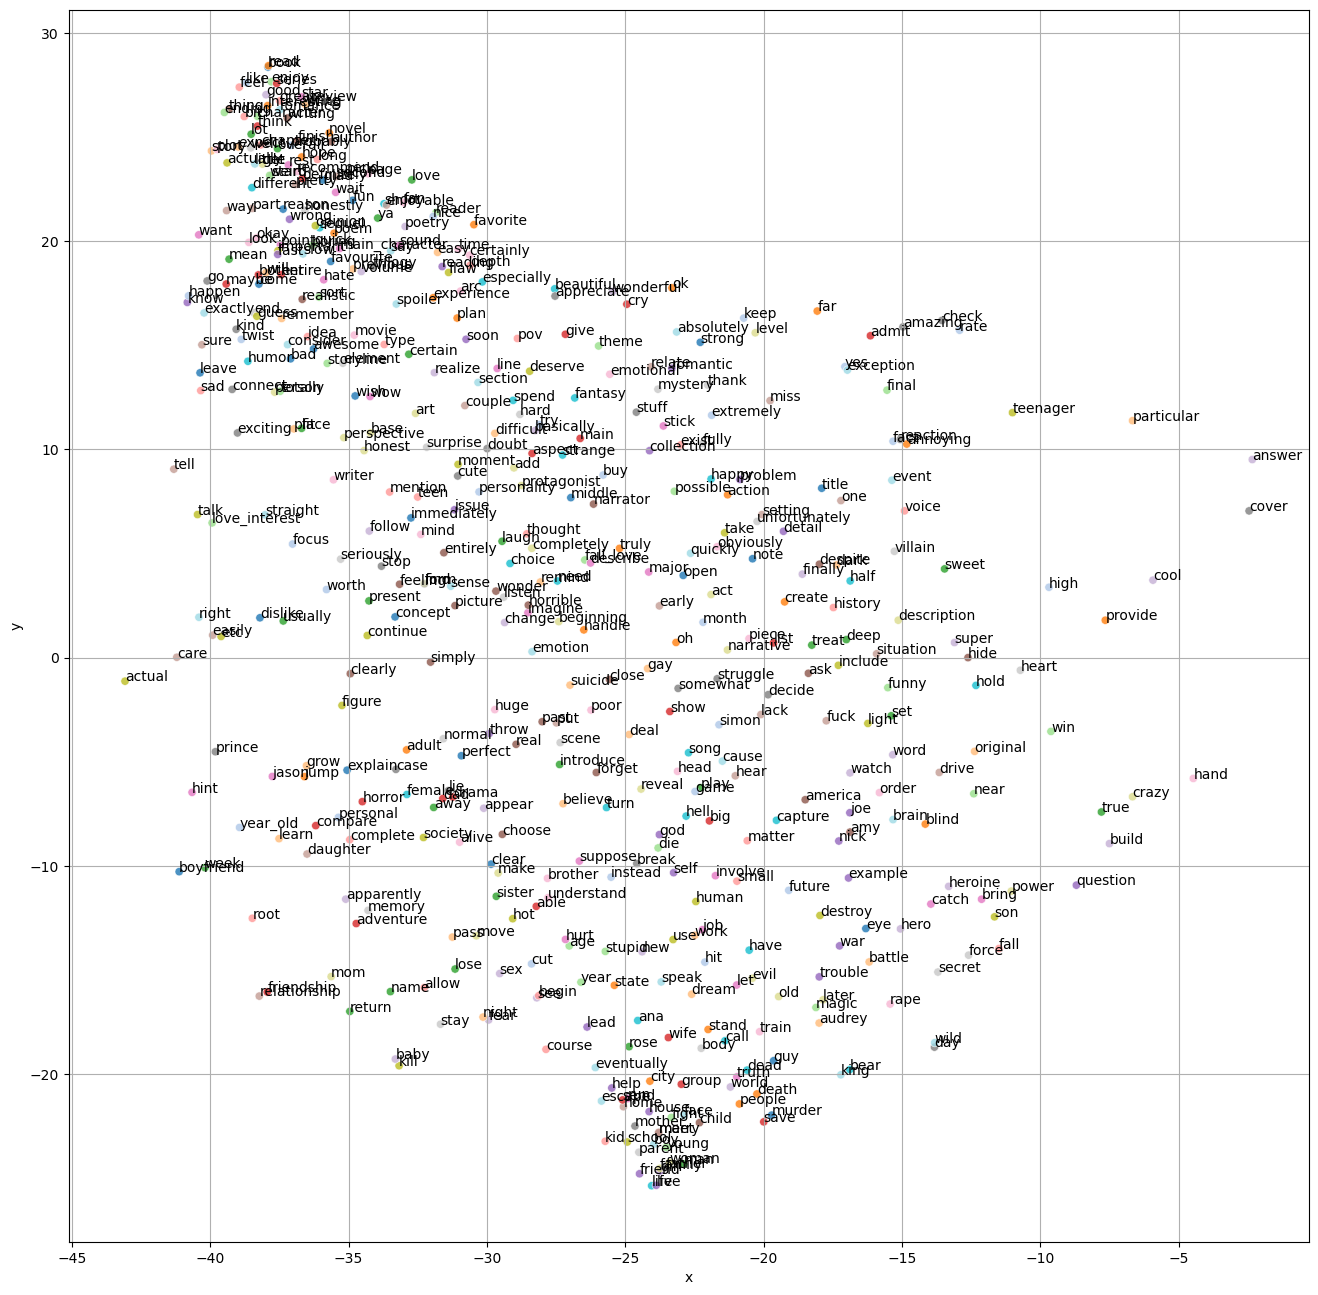

CPU times: user 1.39 s, sys: 189 ms, total: 1.58 s
Wall time: 1.38 s


In [113]:
%%time
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))

# create a DataFrame to store the embeddings
df = pd.DataFrame(wv_skip_tsne[:500], columns=['x', 'y'])
df['word'] = list(wv_skip.key_to_index.keys())[:500]

# plot the embeddings using seaborn scatterplot
sns.scatterplot(data=df, x='x', y='y', hue="word", palette="tab20", alpha=.8, legend=False)

# add annotations for the words
for row in df.itertuples():
    plt.annotate(row.word, xy=(row.x, row.y), fontsize=10)

plt.grid()
plt.show()


In [114]:
#TODO: Comment the plot results

In [115]:
# Free the memory allocated to wv_skip_tsne
del wv_skip_tsne

#### 3.1.3 Sentence embeddings

Notice that our data analysis is concerned not just with the vector representation of mere words but that of entire sentences: the reviews.

A straightforward mechanism to compute the review embeddings is to take the average of all words vector, i.e., compute the mean of all the word vectors belonging to a review.

Because we had already removed rare and very common terms from `corpus_df` we set `min_count = 0` in Word2Vec and that is why we need not to compute the ratio of covered words (it is 1.0) as there is no OOV (Out-of-bag vocabulary). This can be seen using the `get_vocabulary_coverage` function defined below:

In [116]:
def get_vocabulary_coverage(model, gensim_dict):
    # Count the total number of words
    total_words = sum(gensim_dict.dfs.values())

    # Create counters to store the number of words
    # belonging to each type
    covered_words = 0
    oov_words = 0

    # Iterate over the words in the dictionary
    for word, freq in gensim_dict.dfs.items():
        # Check whether a word is also in the vocabulary
        # of the Word2Vec model
        if word in model:
            covered_words += freq
        else:
            oov_words += freq

    # Calculate the coverage
    coverage = covered_words / total_words

    return coverage

In [117]:
%%time
wv_coverage = get_vocabulary_coverage(wv_skip, D)

print(f"The ratio of covered words is {wv_coverage}\n")

The ratio of covered words is 1.0

CPU times: user 3.32 ms, sys: 0 ns, total: 3.32 ms
Wall time: 3.39 ms


As mentioned before, what we need are not so much the individual word vectors but the review vectors if we are to apply a Machine Learning (ML) algorithm so we are going to define the function `get_review_vector` to return the sentence embedding by averaging the individuals word vectors.

In [118]:
def get_review_vector(model, review):
    # We initialize the review vector with all zeros
    vec = np.zeros(model.vector_size)
    # We initialize the counter to count the number of
    # words that are present in a given review
    n_words = 0

    for token in review:
        # Check whether the token is covered
        # in the w2v_model (take) or not (discard)
        if token in model:
            vec += model[token]
            n_words += 1
        else:
            print("\n[OOV] This is not supposed to happen.\n")

    if n_words > 0:
        vec /= n_words  # Take the average
    else:
        print("\n[NO COVERAGE] This is not supposed to happen.\n")  # We have the all zeros vector

    return vec

In [119]:
%%time
# Create a list of review vectors by taking the average of word vectors
review_vectors = [get_review_vector(wv_skip, review_tokens) for review_tokens in corpus_df]

# We check that the length of review_vectors matches
# the number of reviews
print(len(review_vectors))

448
CPU times: user 158 ms, sys: 35.8 ms, total: 194 ms
Wall time: 150 ms


#### 3.1.3 Regression using Word2Vec embeddings

In [120]:
%%time
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(review_vectors, sample_df["rating"], test_size=.3, random_state=42)

CPU times: user 1.87 ms, sys: 16 µs, total: 1.88 ms
Wall time: 1.51 ms


In [121]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Define the SVM regressor
    svm = SVR()

    # Define the hyperparameter grid for grid search
    param_grid = {'C': [1, 3, 5, 7, 9], "kernel": ["rbf", "linear"]}

    # Perform grid search #TODO with cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

CPU times: user 1.07 s, sys: 154 ms, total: 1.22 s
Wall time: 391 ms


In [122]:
# Get the best hyperparameter values from the grid search
best_C = grid_search.best_params_['C']
best_kernel = grid_search.best_params_["kernel"]

# Print best values
print(f"Best C value is {best_C}\nBest kernel choice is {best_kernel}")

Best C value is 9
Best kernel choice is rbf


In [123]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Train an SVM regressor with the best hyperparameters
    svm_best = SVR(C=best_C, kernel=best_kernel)
    svm_best.fit(X_train, y_train)

CPU times: user 29.8 ms, sys: 1.96 ms, total: 31.7 ms
Wall time: 30.7 ms


In [124]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Predict the labels for the test data
    y_pred = svm_best.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False) # RMSE

CPU times: user 22.2 ms, sys: 2.39 ms, total: 24.6 ms
Wall time: 23.6 ms


In [125]:
rmse

1.0564895705709774

#### 3.1.4 Classification using Word2Vec embeddings

In [126]:
%%time
sample_df_cat = pd.DataFrame()
# Convert "rating" column to category data type
sample_df_cat["rating"] = sample_df["rating"].astype("category")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(review_vectors, sample_df_cat["rating"], test_size=.3, random_state=42)

CPU times: user 6.23 ms, sys: 0 ns, total: 6.23 ms
Wall time: 5.95 ms


In [127]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Define the SVM regressor
    svm = SVC()

    # Define the hyperparameter grid for grid search
    param_grid = {'C': [1, 3, 5, 7, 9], "kernel": ["rbf", "linear"]}

    # Perform grid search #TODO with cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

/home/leibniz/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 1.26 s, sys: 144 ms, total: 1.4 s
Wall time: 318 ms


In [128]:
# Get the best hyperparameter values from the grid search
best_C = grid_search.best_params_['C']
best_kernel = grid_search.best_params_["kernel"]

# Print best values
print(f"Best C value is {best_C}\nBest kernel choice is {best_kernel}")

Best C value is 1
Best kernel choice is rbf


In [129]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Train an SVM regressor with the best hyperparameters
    svm_best = SVC(C=best_C, kernel=best_kernel)
    svm_best.fit(X_train, y_train)

CPU times: user 35.8 ms, sys: 1.96 ms, total: 37.7 ms
Wall time: 36.7 ms


In [130]:
%%time
with parallel_backend("threading", n_jobs=os.cpu_count()):
    # Predict the labels for the test data
    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test.astype("float64"), y_pred)

CPU times: user 29.2 ms, sys: 1.93 ms, total: 31.2 ms
Wall time: 30.2 ms


In [131]:
accuracy

0.4222222222222222

### 3.2 Glove

#TODO

### 3.3 FastText

#TODO

## 4. Topic modelling

### 4.1 Latent Semantic Indexing (LSI)

#TODO

### 4.2 Latent Direchlet Allocation (LDA)

#TODO (we will be using Gensim, not Mallet)

## 5. Dash

#TODO